### Les selvsamlede data inn i python

Dette skriptet er et eksempel på hvordan dere kan lese deres egne data inn i python. Datasettet her er hentet inn av Ragnhild Hannaas med samme type logger som det dere bruker, så det skal se nokså likt ut for dere. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Dette er stien til filen du vil laste inn. Bytt den ut med stien til der du har de selvinnhentede dataene dine. 

In [2]:
sti='W:/Work/Documents/EkteData/EkteData/data'
fil='/4-6_januar_Temperaturegistrering_AB-vei.csv'

Forklaring på keywordsene i filinnlesingen under: 
- `sep=','`: kolonnene i csv-filen er skilt med komma. Dette er default for csv-filer, så denne spesifiseringen er strengt tatt overflødig. 
- `header=0`: den første linjen i filen er en "header" altså ikke faktiske data men forklaring på dataene. 
- `engine=python`: siden Celcius en angitt med grad-tegn (special character) må man spesifisere engine. 
- `parse:dates=['Time']`: konverterer kolonnen med tid til "Timestamp" som er lett å jobbe med for tid. 

In [3]:
df=pd.read_csv(
    sti+fil, sep=',', header=0, engine='python',
    parse_dates=['Time'], 
    encoding= 'unicode_escape'
)

In [4]:
df

,Temp AB-vei,Time,Celsius(°C),Comments,Serial Number
0,1,2022-01-04 15:00:00,4.0,NaN,60039020.0
1,2,2022-01-04 15:01:00,4.0,NaN,NaN
2,3,2022-01-04 15:02:00,4.0,NaN,NaN
3,4,2022-01-04 15:03:00,4.0,NaN,NaN
4,5,2022-01-04 15:04:00,4.0,NaN,NaN
...,...,...,...,...,...
2569,2570,2022-01-06 09:49:00,9.5,NaN,NaN
2570,2571,2022-01-06 09:50:00,10.5,NaN,NaN
2571,2572,2022-01-06 09:51:00,11.0,NaN,NaN
2572,2573,2022-01-06 09:52:00,12.0,NaN,NaN


Konverter pandas DataFramen til et numpy array. Dette tar hånd om tidsaksen bedre når man plotter. 

In [5]:
data=df.to_numpy()

In [6]:
data

array([[1, Timestamp('2022-01-04 15:00:00'), 4.0, nan, 60039020.0],
       [2, Timestamp('2022-01-04 15:01:00'), 4.0, nan, nan],
       [3, Timestamp('2022-01-04 15:02:00'), 4.0, nan, nan],
       ...,
       [2572, Timestamp('2022-01-06 09:51:00'), 11.0, nan, nan],
       [2573, Timestamp('2022-01-06 09:52:00'), 12.0, nan, nan],
       [2574, Timestamp('2022-01-06 09:53:00'), 12.5, nan, nan]],
      dtype=object)

Lagre tidskolonnen og temperaturkolonnen i hver sine vektorer: `tid` og `temp`

In [7]:
tid=np.copy(data[:,1])
temp=np.copy(data[:,2])

Lag en figur for å inspisere datasettet. 

(738159.625, 738161.4118055556)

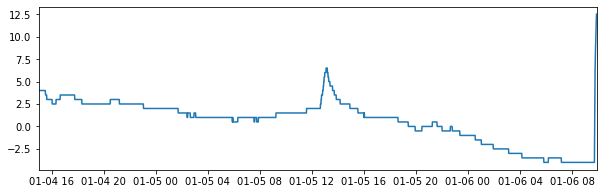

In [8]:
plt.figure(figsize=(10,3))
plt.plot(tid,temp)
plt.xlim(tid[0], tid[-1])

Dette ser litt rart ut - her trenger vi å vite litt om datainnhentingsprosessen for å forstå hva som må forklares av feilkilder og hva som er faktiske temperaturendringer. 

Det er for eksempel to hopp i temperatur: ett etter kl 12 den 5. januar, og ett helt på slutten av tidsserien. Er instrumentet blitt flyttet? Lå instrumentet i skyggen eller i solen? Når man samler inn data er det viktig å holde oversikten over slike forhold som kan påvirke datasettet. 

En annen ting som kan være lurt å sjekke om man bruker et instrument man ikke kjenner til så godt er om den har lagret data med konstant frekvens. I figuren over ser det litt ut som om at noen perioder har høyere oppløsning enn andre. Er det hull i datasettet eller er bare temperaturen veldig jevn i noen perioder?

In [ ]:
# Pandas har en funksjon for å sjekke dette: pd.infer_freq. 
# Resultatet er 'T', altså er det konstant frekvens på timesoppløsning.
pd.infer_freq(df['Time'])


### Hvordan behandle slike avvik?

sett til NaN
fyll med gjennomsnittsverdier
interpoler med funksjon

Ofte er det en god løsning å sette verdier man mangler eller er usikre på om er gyldige til `NaN`. Da får man et hull i datasettet sitt, men det er bedre med et hull i en figur enn verdier man vet ikke er til å stole på. 

Den siste "spiken" i figuren over er et tilfelle hvor det opplagt er best å sette verdien til `NaN`. Siden det er helt på slutten av tidsserien har det veldig lite å si å fjerne disse datapunktene. Første steg er å finne verdiene som må settes til `NaN` for å få fjernet denne spiken:

In [9]:
# Siden dette er et så lite datasett kan jeg inspisere de siste verdiene for å finne 
# hva jeg vil sette til NaN.
temp[-20:]

array([-4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -0.5,
       3.5, 6.0, 7.5, 8.5, 9.5, 10.5, 11.0, 12.0, 12.5], dtype=object)

In [10]:
temp[-10:]

array([-0.5, 3.5, 6.0, 7.5, 8.5, 9.5, 10.5, 11.0, 12.0, 12.5],
      dtype=object)

In [16]:
# Jeg vil sette de siste 10 verdiene til NaN: det er lenge stabilt på -4 før det begynner å øke
temp[-10:]=np.nan

(738159.625, 738161.4118055556)

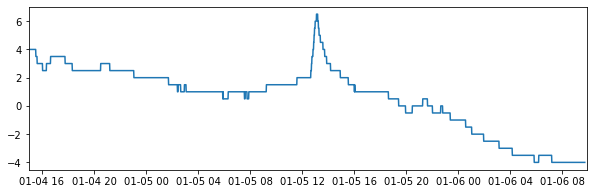

In [17]:
plt.figure(figsize=(10,3))
plt.plot(tid,temp)
plt.xlim(tid[0], tid[-1])

In [19]:
temp[-20:]

array([-4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan], dtype=object)

#### Hva om det ikke er praktisk mulig å fikse det manuelt?

Hadde dette vært et større datasett ville ikke manuell inspeksjon fungert. Det samme gjelder om det var flere slike spiker. En fremgangsmåte som kan fungere er å finne hvor det skjer store endringer i verdier. Dette vil identifisere spiker. Vi prøver:

In [20]:
# Last inn temp på nytt for et nytt forsøk:
temp=np.copy(data[:,2])

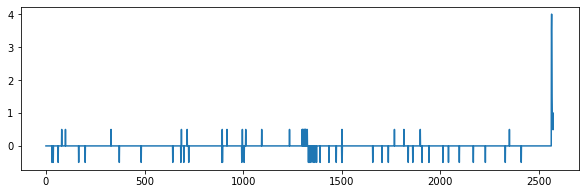

In [21]:
# plot differansen mellom hvert datapunkt:
plt.figure(figsize=(10,3))
diff=np.diff(temp)
plt.plot(diff)

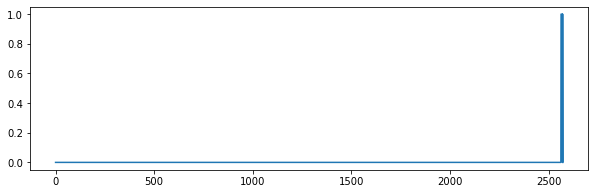

In [22]:
# Figuren over viser hvor mye verdiene seg. Dette kan hjelpe oss å sette en grense for hvor mye
# endring vi ser på som fysisk realistisk. 
# Jeg velger å sette grensen på 1 grad.
plt.figure(figsize=(10,3))
plt.plot(diff>=1)
plt.show()
# Alle disse tilfellene er konsentrert i slutten av tidsserien, som forventet. 


In [23]:
# What is the first index where the temperature difference between two recordings is larger than 1?
nanind=np.where((diff>=1)==1)[0][0]

In [24]:
# Vi kutter disse veridene fra temp
temp=temp[:nanind]

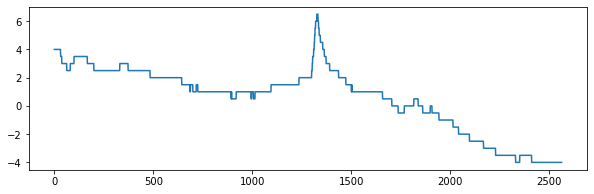

In [25]:
plt.figure(figsize=(10,3))
plt.plot(temp)

Men hva med **spiken i midten av tidsserien**? Denne er ikke like lett å identifisere i tid: Endringen er ikke så strek som spiken på slutten var, og verdiene er ikke så høye. Siden tidsseriene vi jobber med i dette kurset generelt ikke er så lange identifiserer vi denne manuelt og ser på tre forskjellige måter å behandle disse datapunktene:
- sett til NaN
- sett til gjennomsnittet av punktene ved siden
- bruk en funksjon til å interpolere. 

Om det ikke var praktisk mulig å identifisere spiken manuelt måtte vi laget en metode som identifiserte den for oss. I figuren over differanse har f.eks. mange tidssteg på rad stor differanse der midt-spiken er. Dette kunne vært et kritere i en slik metode. 

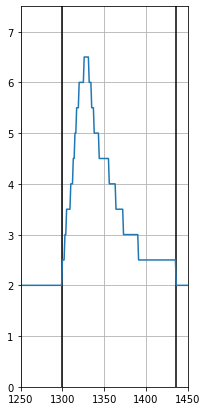

In [31]:
plt.figure(figsize=(3,7))
plt.plot(temp)
plt.grid()
plt.xlim(1250, 1450)
plt.ylim(0, 7.5)

plt.vlines(1299, 0, 7.5, 'k')
plt.vlines(1436, 0, 7.5, 'k')

Vi begrenser området vi vil behandle til verdiene mellom indeks 1299 og 1436.

#### Sett til NaN:

In [32]:
temp[1299:1436+1]=np.nan

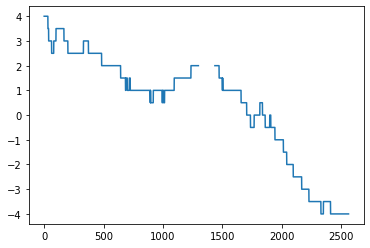

In [33]:
plt.plot(temp)
plt.show()

#### Sett til gjennomsnittet av punktene til sidene

In [34]:
# Finn gjennomsnittet til punktene ved siden av. Bruk f.eks. 10 punkter fra hver side.
mean=np.nanmean(temp[1289:1447], dtype='float64')
mean

2.0

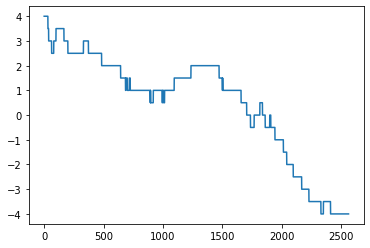

In [35]:
temp[1299:1436+1]=mean

plt.plot(temp)
plt.show()

#### Bruk en funksjon til å interpolere

Vi bruker pandas sin fuksjon `interpolate` til å lineært interpolere `temp`. 

In [36]:
temp=np.copy(data[:,2])
temp=np.array(temp, dtype='float64')
temp=temp[:-10]
temp[1299:1436+1]=np.nan

In [37]:
temp=pd.DataFrame(temp)
temp=temp.interpolate()

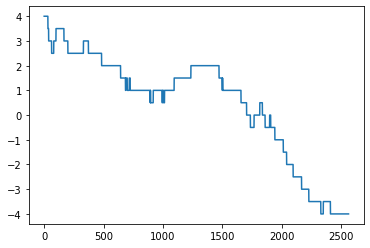

In [38]:
plt.plot(temp)